# Цель лабораторной работы

Изучение ансамблей моделей машинного обучения.

# Задание

1. Выберите набор данных (датасет) для решения задачи классификации или регресии.

2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.

3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.

4. Обучите следующие ансамблевые модели:

- одну из моделей группы бэггинга (бэггинг или случайный лес или сверхслучайные деревья);
- одну из моделей группы бустинга;
- одну из моделей группы стекинга.
5. (+1 балл на экзамене) Дополнительно к указанным моделям обучите еще две модели:

- Модель многослойного персептрона. По желанию, вместо библиотеки scikit-learn возможно использование библиотек TensorFlow, PyTorch или других аналогичных библиотек.
- Модель МГУА с использованием библиотеки - https://github.com/kvoyager/GmdhPy (или аналогичных библиотек). Найдите такие параметры запуска модели, при которых она будет по крайней мере не хуже, чем одна из предыдущих ансамблевых моделей.
6. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей. 

# Ход выполнения работы

In [1]:
import math
import uuid
from operator import itemgetter

import gmdhpy.gmdh
import numpy as np
import pandas as pd
from io import StringIO
import graphviz
import pydotplus
from typing import Dict, Tuple

from dython.nominal import associations
from scipy import stats
from sklearn.neural_network._multilayer_perceptron import MLPClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics._classification import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from IPython.core.display import HTML, Image
from sklearn.tree import export_text, export_graphviz
import graphviz
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

In [2]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [3]:
data.shape

(299, 13)

In [4]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [6]:
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [7]:
# Получаем метки категориальных признаков
cat_features = []
for col in data.columns:
    dt = str(data[col].dtype)
    if dt == "object":
        cat_features.append(col)
cat_features

[]

In [8]:
# Функция построения полной матрицы корреляции
def plot_full_corr_matrix(dataset_, nominal_columns_):
    res_corr = associations(
        dataset=dataset_,
        nominal_columns=nominal_columns_,
        cmap=sns.diverging_palette(220, 20, as_cmap=True),
        title='Полная матрица корреляции',
        clustering=True,
        figsize=(18,18),
        plot=False,
        compute_only=True,
        mark_columns=True,
    )
    corr_matrix = res_corr['corr']
    plt.figure(figsize=(24,16))
    sns.heatmap(
        data=corr_matrix,
        square=True,
        center=0,
        cmap=sns.diverging_palette(220, 20, as_cmap=True),
        annot=True,
        vmin=-1.0,
        vmax=1.0
    )
    plt.show()

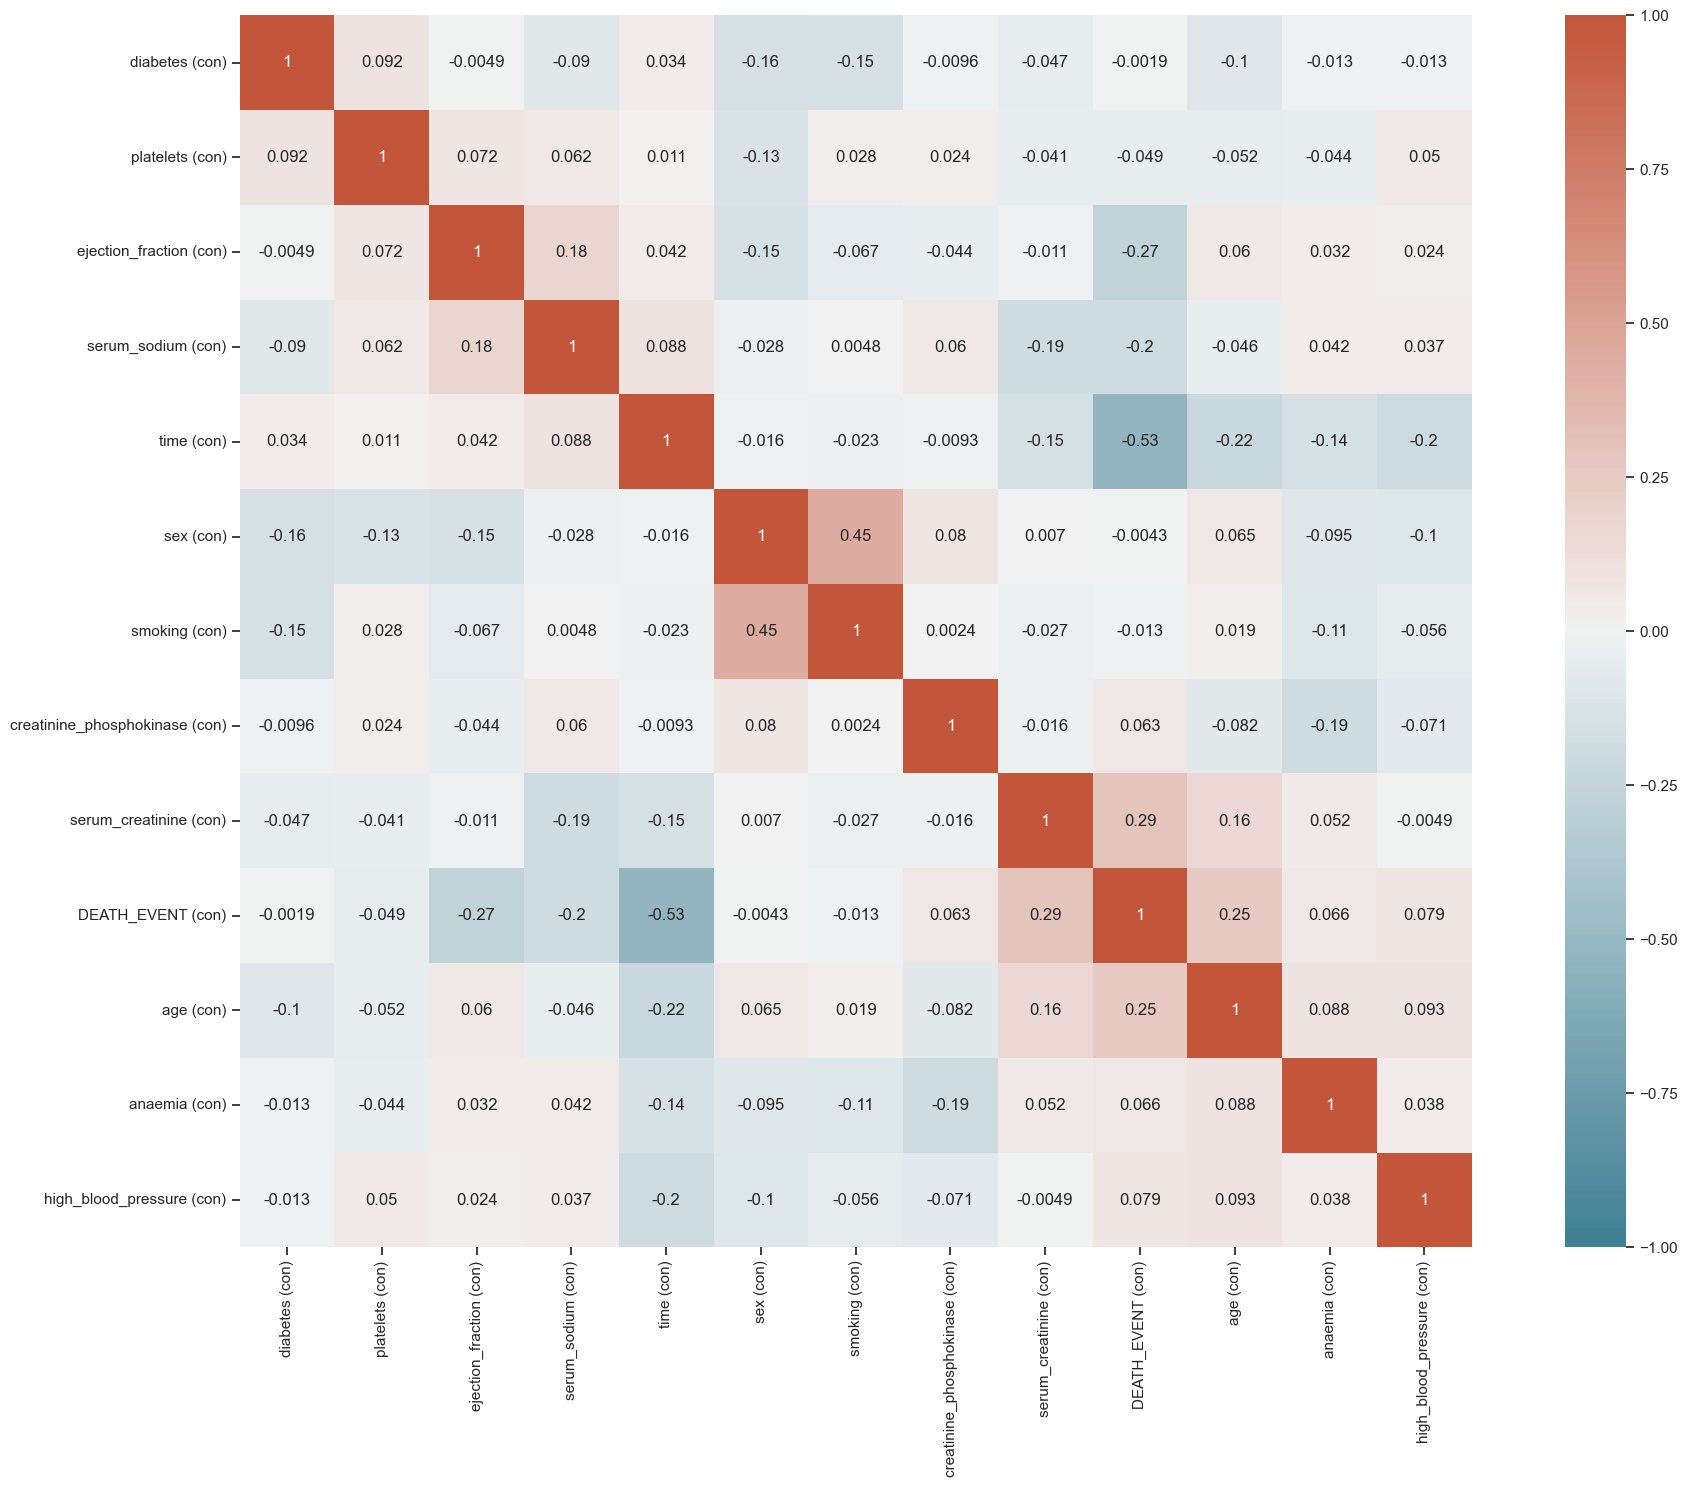

In [9]:
plot_full_corr_matrix(dataset_=data, nominal_columns_=cat_features)

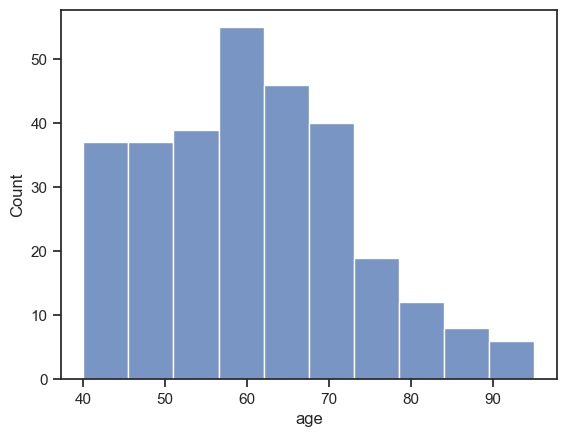

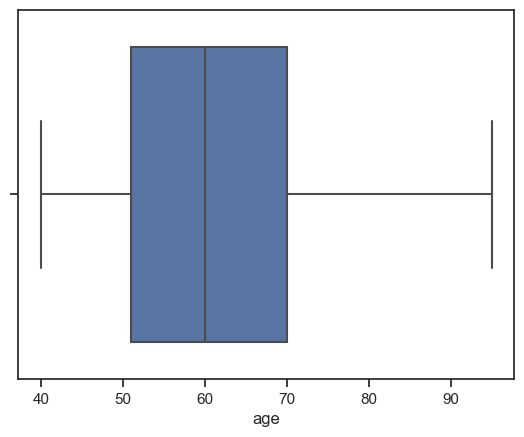

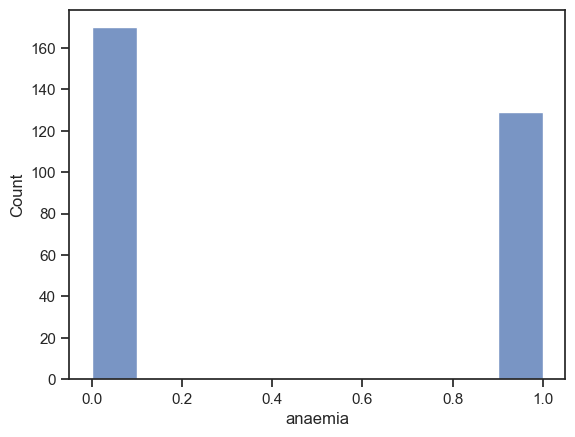

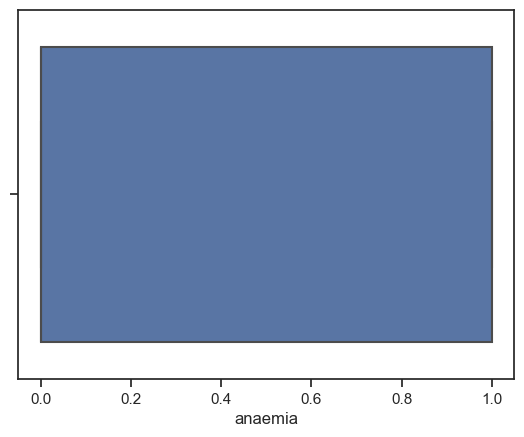

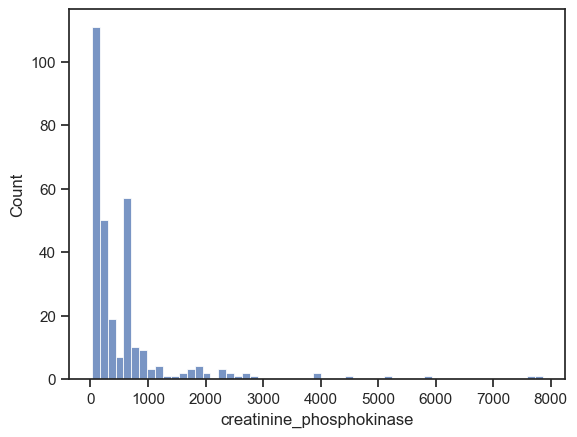

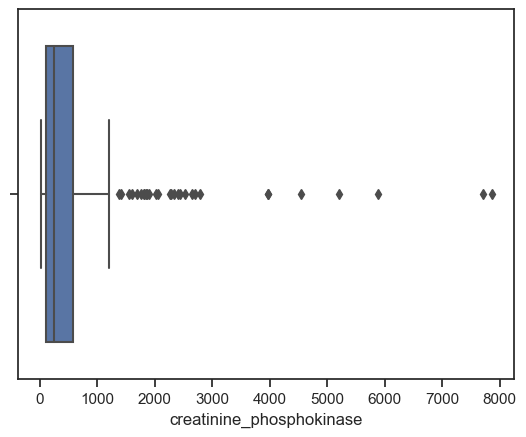

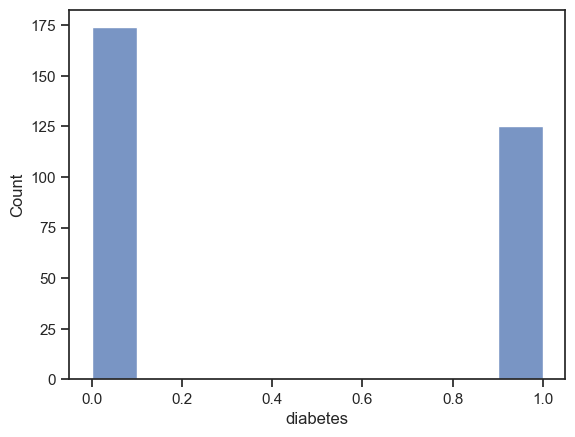

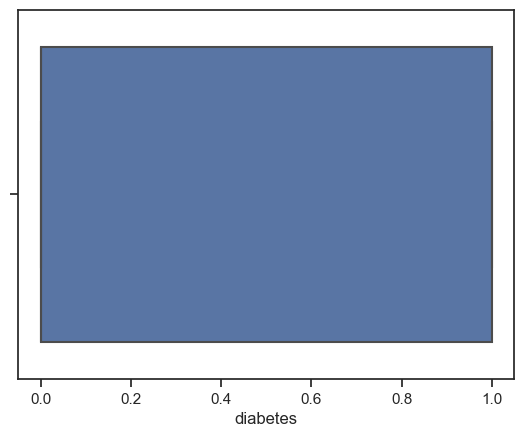

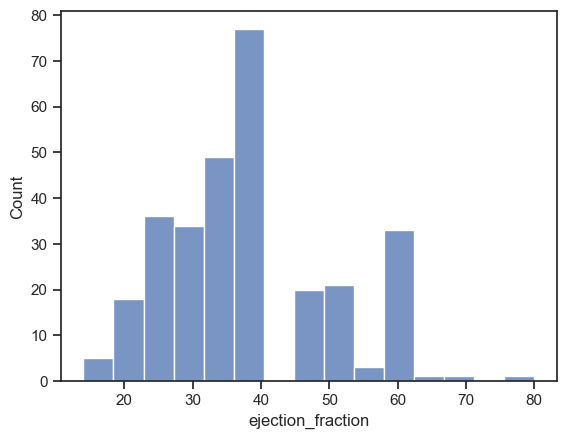

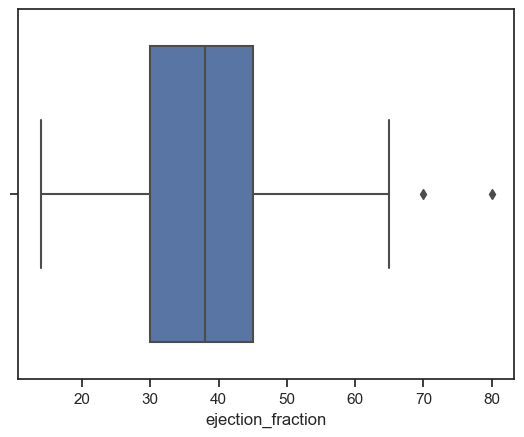

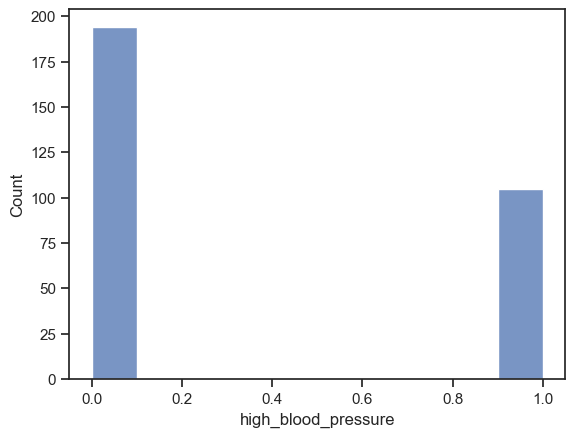

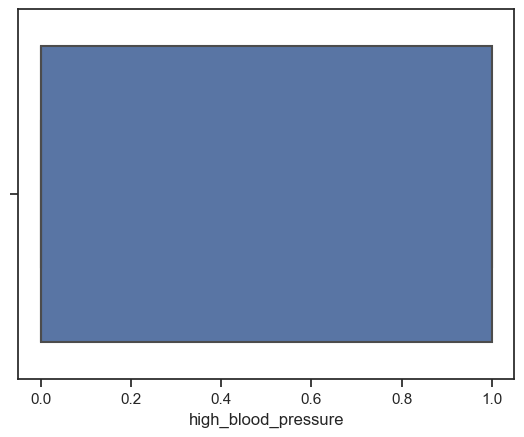

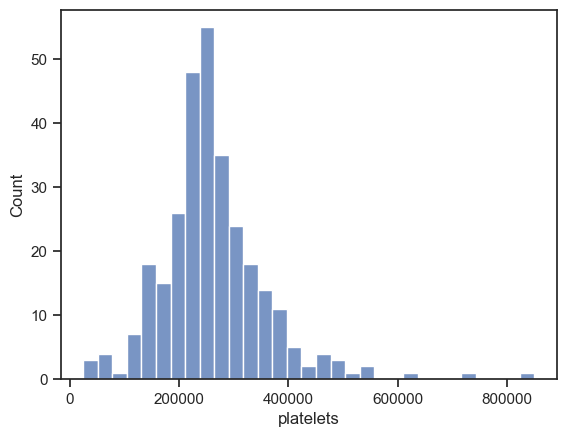

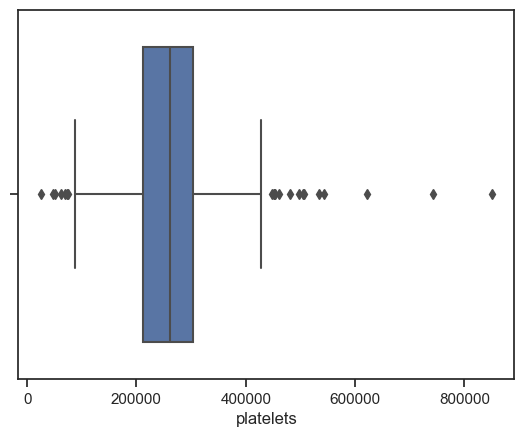

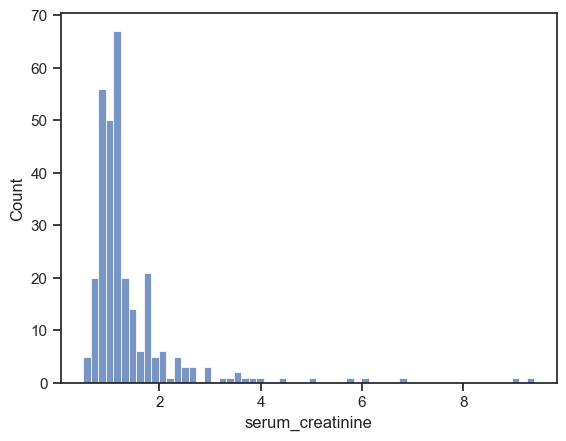

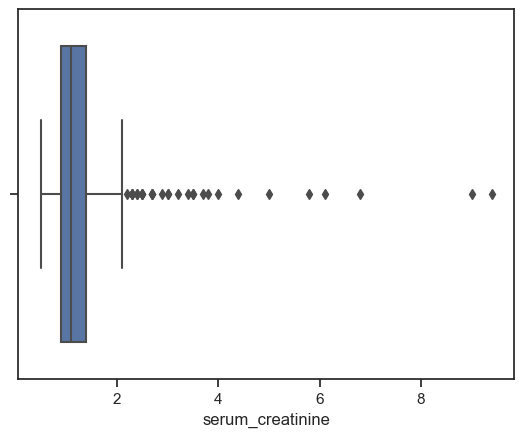

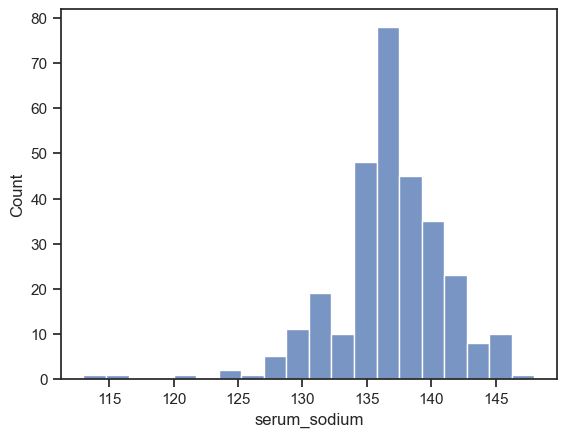

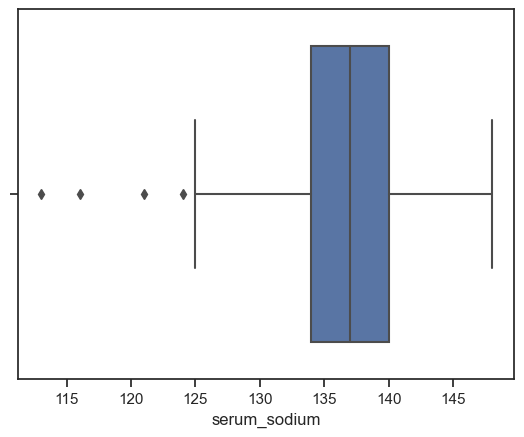

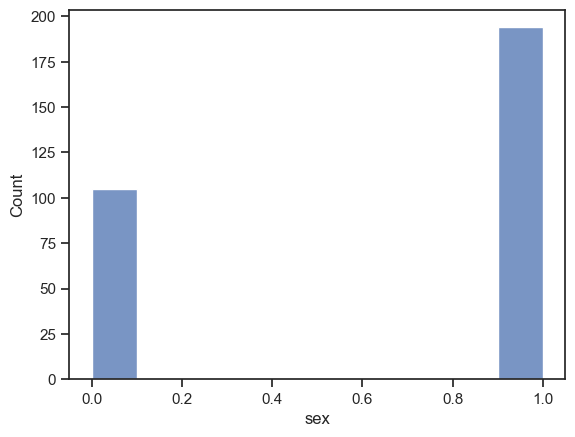

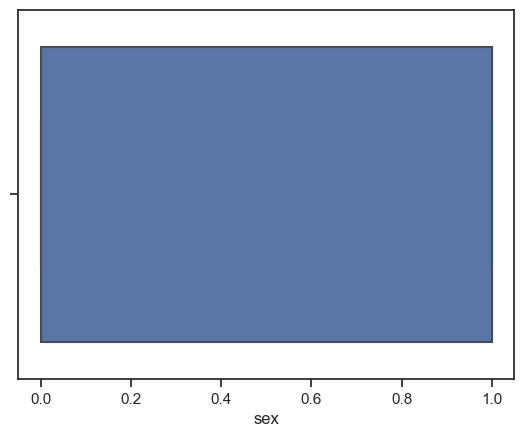

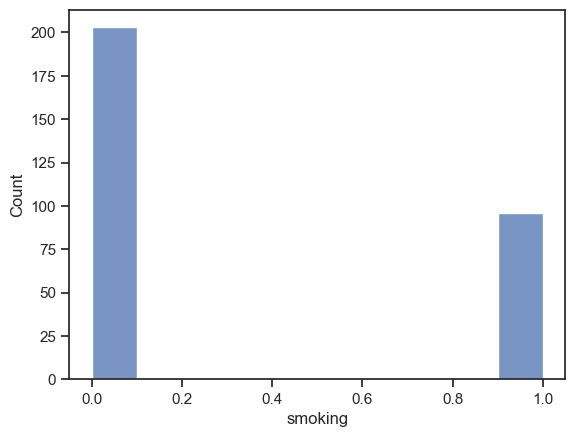

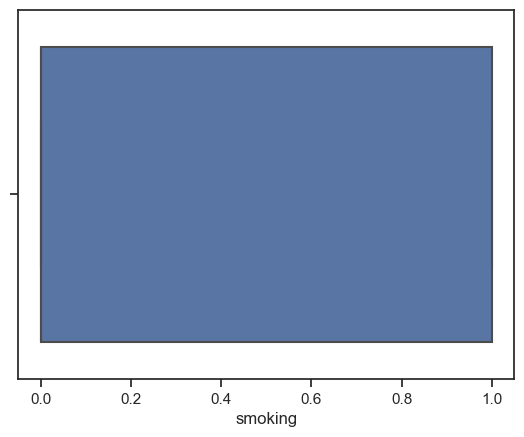

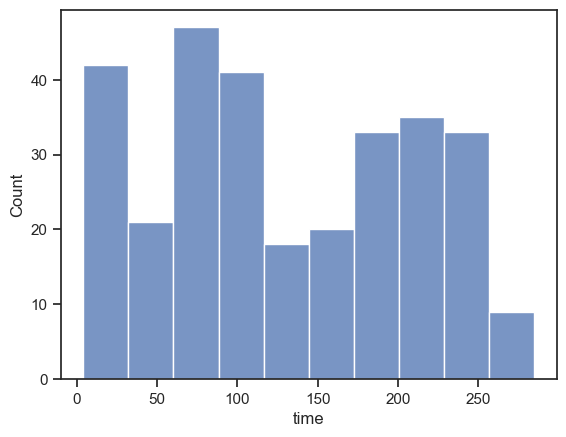

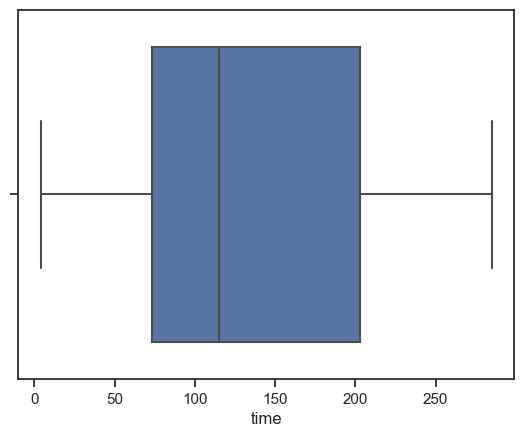

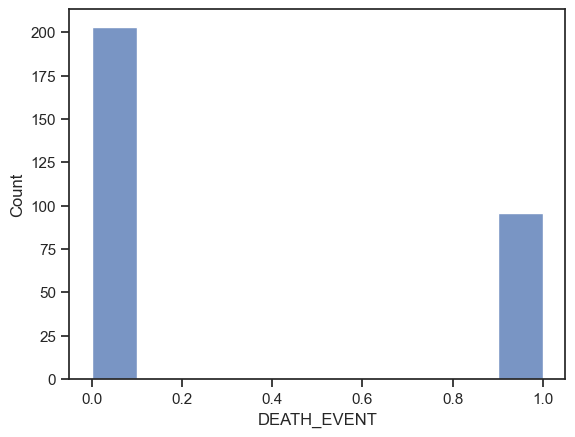

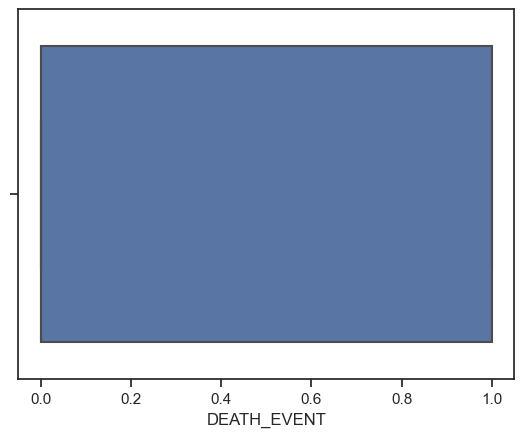

In [10]:
for col in data.drop(cat_features, axis=1, inplace=False):
    sns.histplot(data=data, x=col)
    plt.show()
    sns.boxplot(data=data, x=col)
    plt.show()

In [11]:
# Выбросы
def remove_outliers(df, label):
    q1 = df[label].quantile(0.25)
    q3 = df[label].quantile(0.75)
    iqr = (q3 - q1)
    fil = (df[label] >= q1 - 1.5 * iqr) & (df[label] <= q3 + 1.5 * iqr)
    return df.loc[fil]

In [12]:
col_to_remove_outliers_in = [
    "age",
    "serum_sodium"
]

for col in col_to_remove_outliers_in:
    data = remove_outliers(data, col)

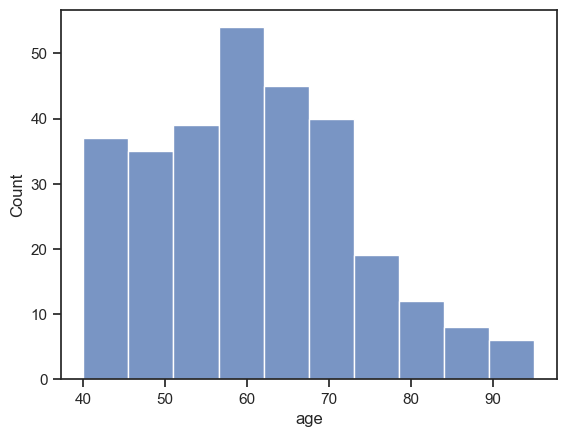

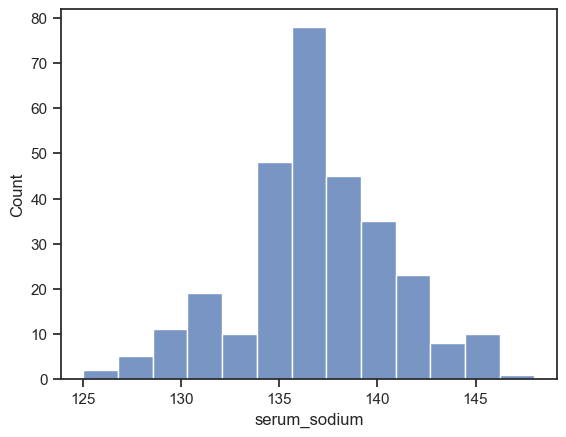

In [13]:
for col in col_to_remove_outliers_in:
    sns.histplot(data=data, x=col)
    plt.show()

In [14]:
# Итоговый набор данных
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [15]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [16]:
def plot_validation_curve(estimator, title, X, y,
                          param_name, param_range, cv,
                          scoring='accuracy'):

    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.8, 1.05)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

In [17]:
# Разбиение на матрицу объекты-признаки и целевой признак (таргет)
X = data.drop("DEATH_EVENT", axis=1).values
y = data["DEATH_EVENT"].values
X, y

(array([[7.500e+01, 0.000e+00, 5.820e+02, ..., 1.000e+00, 0.000e+00,
         4.000e+00],
        [5.500e+01, 0.000e+00, 7.861e+03, ..., 1.000e+00, 0.000e+00,
         6.000e+00],
        [6.500e+01, 0.000e+00, 1.460e+02, ..., 1.000e+00, 1.000e+00,
         7.000e+00],
        ...,
        [4.500e+01, 0.000e+00, 2.060e+03, ..., 0.000e+00, 0.000e+00,
         2.780e+02],
        [4.500e+01, 0.000e+00, 2.413e+03, ..., 1.000e+00, 1.000e+00,
         2.800e+02],
        [5.000e+01, 0.000e+00, 1.960e+02, ..., 1.000e+00, 1.000e+00,
         2.850e+02]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 

In [18]:
# Формирование обучающей и тестовой выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 9)

<module 'matplotlib.pyplot' from 'C:\\Users\\Xiaomi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

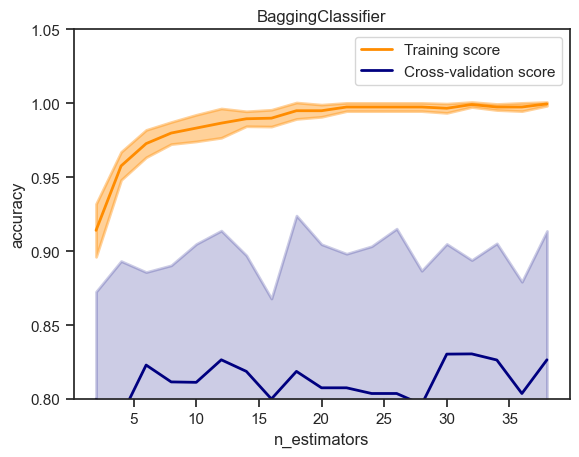

In [19]:
plot_validation_curve(BaggingClassifier(), 'BaggingClassifier',
                      X_train, y_train,
                      param_name='n_estimators', param_range=range(2, 40, 2),
                      cv=10, scoring="accuracy")

C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166:

C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166:

C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166:

C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166:

C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166:

<module 'matplotlib.pyplot' from 'C:\\Users\\Xiaomi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

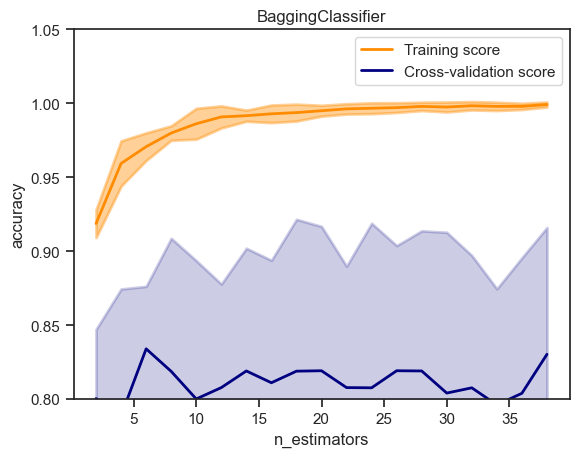

In [20]:
plot_validation_curve(BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=13)), 'BaggingClassifier',
                      X_train, y_train,
                      param_name='n_estimators', param_range=range(2, 40, 2),
                      cv=10, scoring="accuracy")

In [21]:
# Обучим классификатор на 10 деревьях
bc1 = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=10,
    oob_score=True,
    random_state=9,
)
bc1.fit(X_train, y_train)

y_train_predicted = bc1.predict(X_train)
y_test_predicted = bc1.predict(X_test)
print(classification_report(y_train, y_train_predicted), classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       180
           1       1.00      0.96      0.98        85

    accuracy                           0.99       265
   macro avg       0.99      0.98      0.99       265
weighted avg       0.99      0.99      0.99       265
               precision    recall  f1-score   support

           0       0.87      0.91      0.89        22
           1       0.71      0.62      0.67         8

    accuracy                           0.83        30
   macro avg       0.79      0.77      0.78        30
weighted avg       0.83      0.83      0.83        30



C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


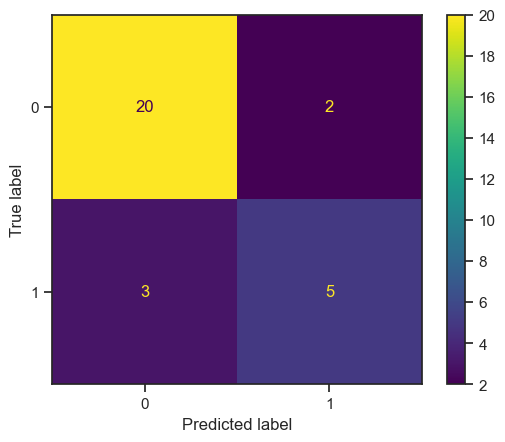

In [22]:
cm_log_bag = confusion_matrix(y_test, y_test_predicted, labels = bc1.classes_)
display_ = ConfusionMatrixDisplay(
    confusion_matrix=cm_log_bag
)
display_.plot()

In [23]:
bin_array = np.zeros((5, X_train.shape[0]))
for i in range(5):
    for j in bc1.estimators_samples_[i]:
        bin_array[i][j] = 1
bin_array

array([[1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [24]:
# Оценим Out-of-bag error, теоретическое значение 37%
for i in range(5):
    cur_data = bin_array[i]
    len_cur_data = len(cur_data)
    sum_cur_data = sum(cur_data)
    (len(bin_array[0]) - sum(bin_array[0])) / len(bin_array[0])
    oob_i = (len_cur_data - sum_cur_data) / len_cur_data
    print('Для модели № {} размер OOB составляет {}%'.format(i+1, round(oob_i, 4)*100.0))

Для модели № 1 размер OOB составляет 33.58%
Для модели № 2 размер OOB составляет 36.230000000000004%
Для модели № 3 размер OOB составляет 35.85%
Для модели № 4 размер OOB составляет 38.11%
Для модели № 5 размер OOB составляет 40.75%


In [25]:
# Out-of-bag error, возвращаемый классификатором
# Для классификации используется метрика accuracy
bc1.oob_score_, 1-bc1.oob_score_

(0.7849056603773585, 0.21509433962264146)

In [26]:
# Вероятность принадлежности классам
# Можем анализировать, где не уверены
bc1.oob_decision_function_

array([[0.25      , 0.75      ],
       [0.75      , 0.25      ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.25      , 0.75      ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.5       , 0.5       ],
       [0.25      , 0.75      ],
       [0.75      , 0.25      ],
       [0.8       , 0.2       ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.66666667, 0.33333333],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.4       , 0.6       ],
       [0.33333333, 0.66666667],
       [0.5       , 0.5       ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.16666667, 0.83333333],
       [0.71428571, 0.28571429],
       [1.        , 0.        ],
       [0.5       , 0.5       ],
       [0.        , 1.        ],
       [0.

In [27]:
column_labels = data.drop("DEATH_EVENT", axis=1).columns

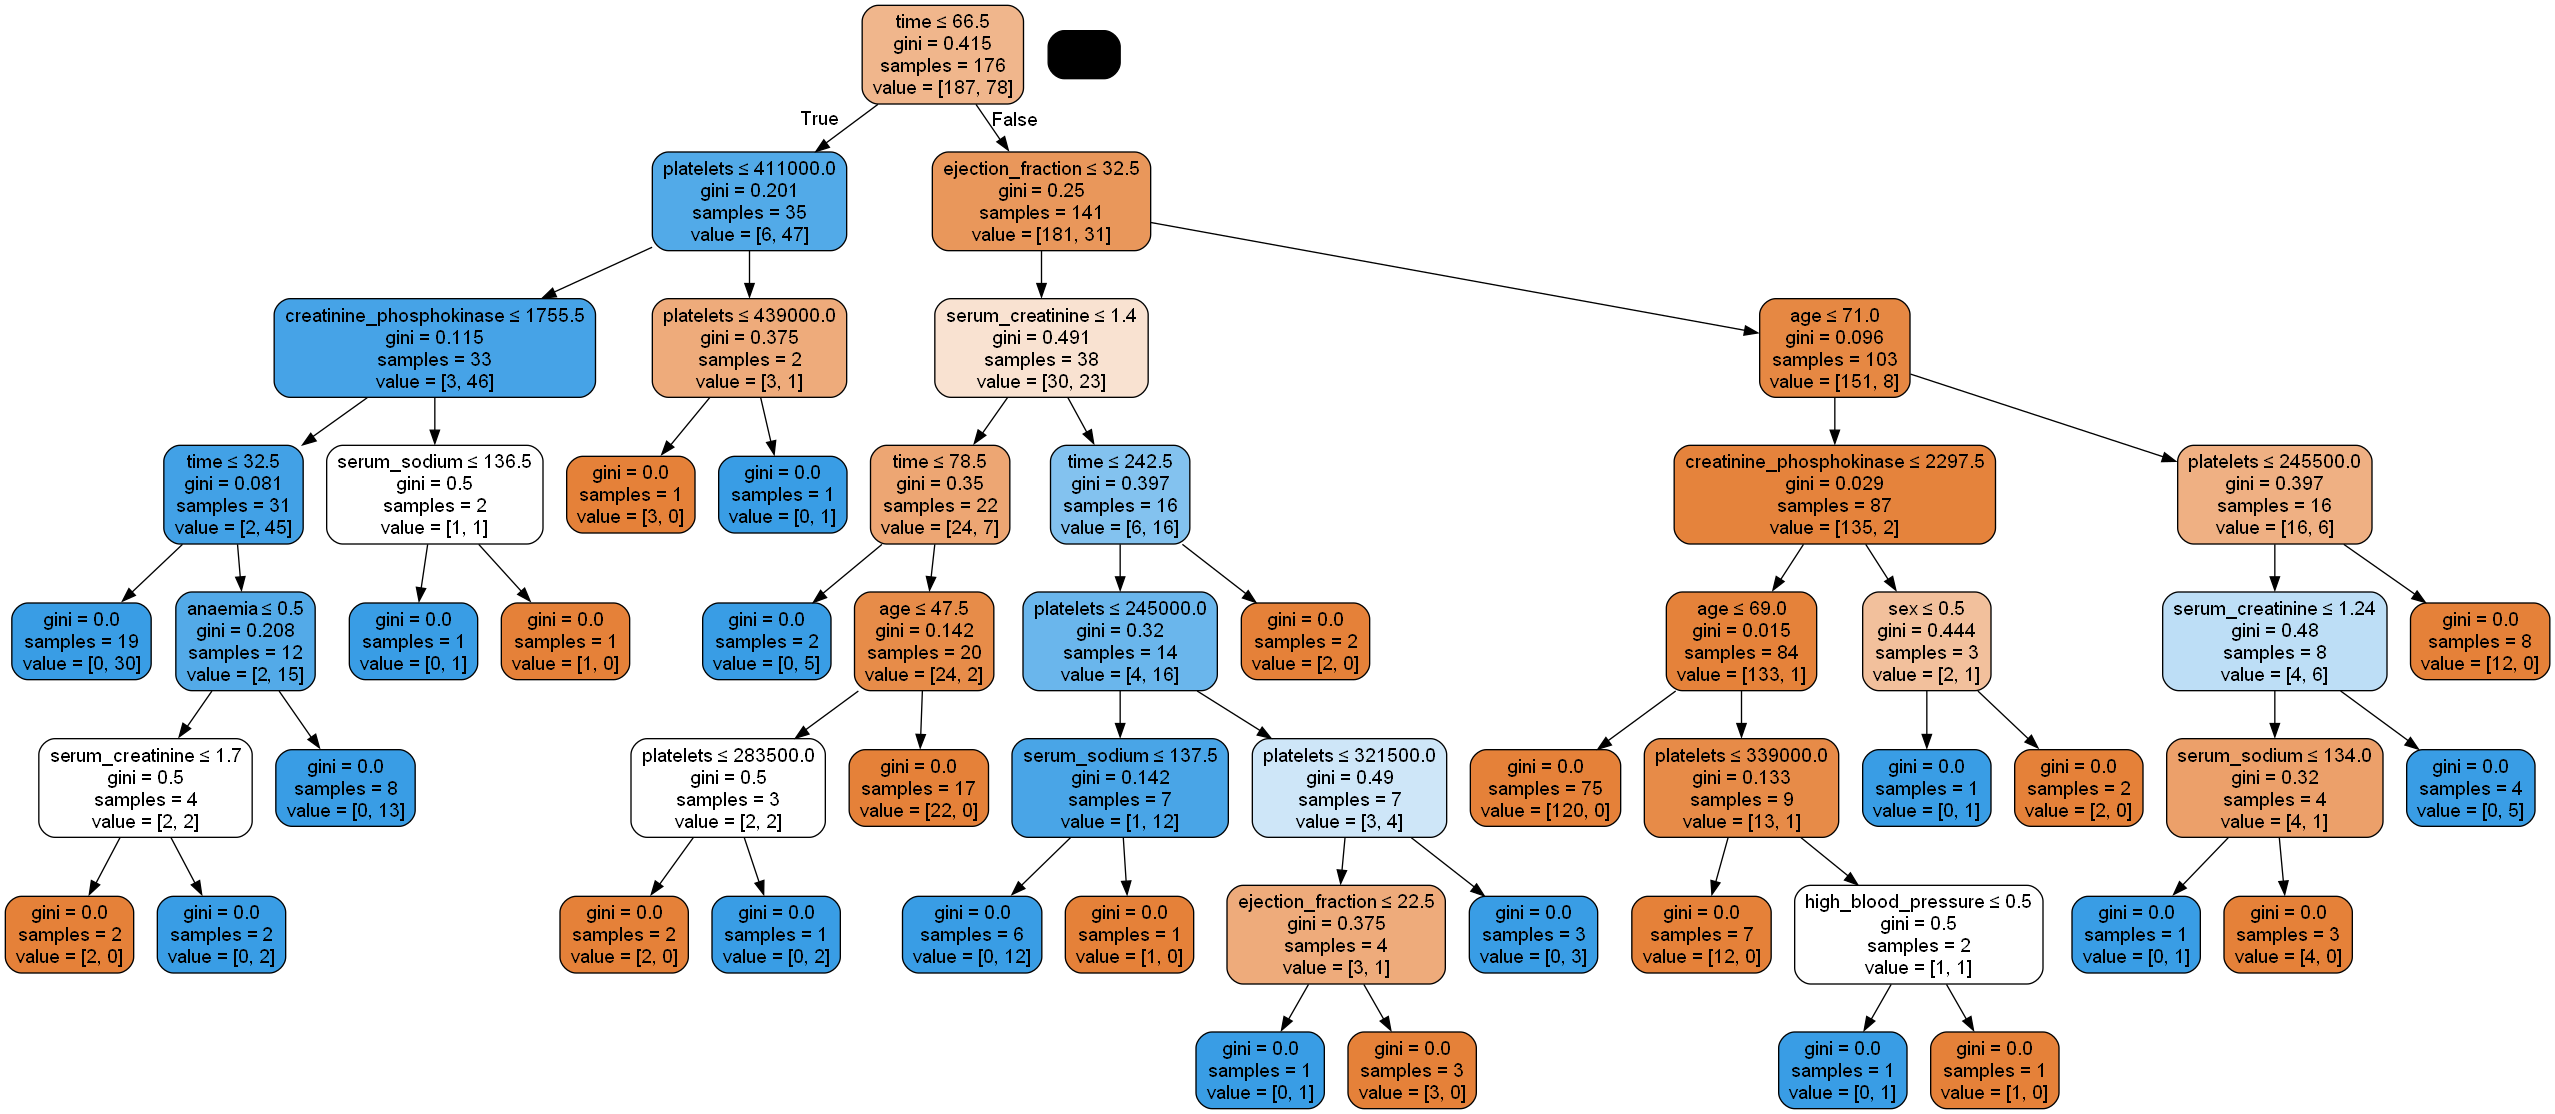

In [28]:
# Визуализация обученных решающих деревьев
Image(get_png_tree(bc1.estimators_[0], column_labels))

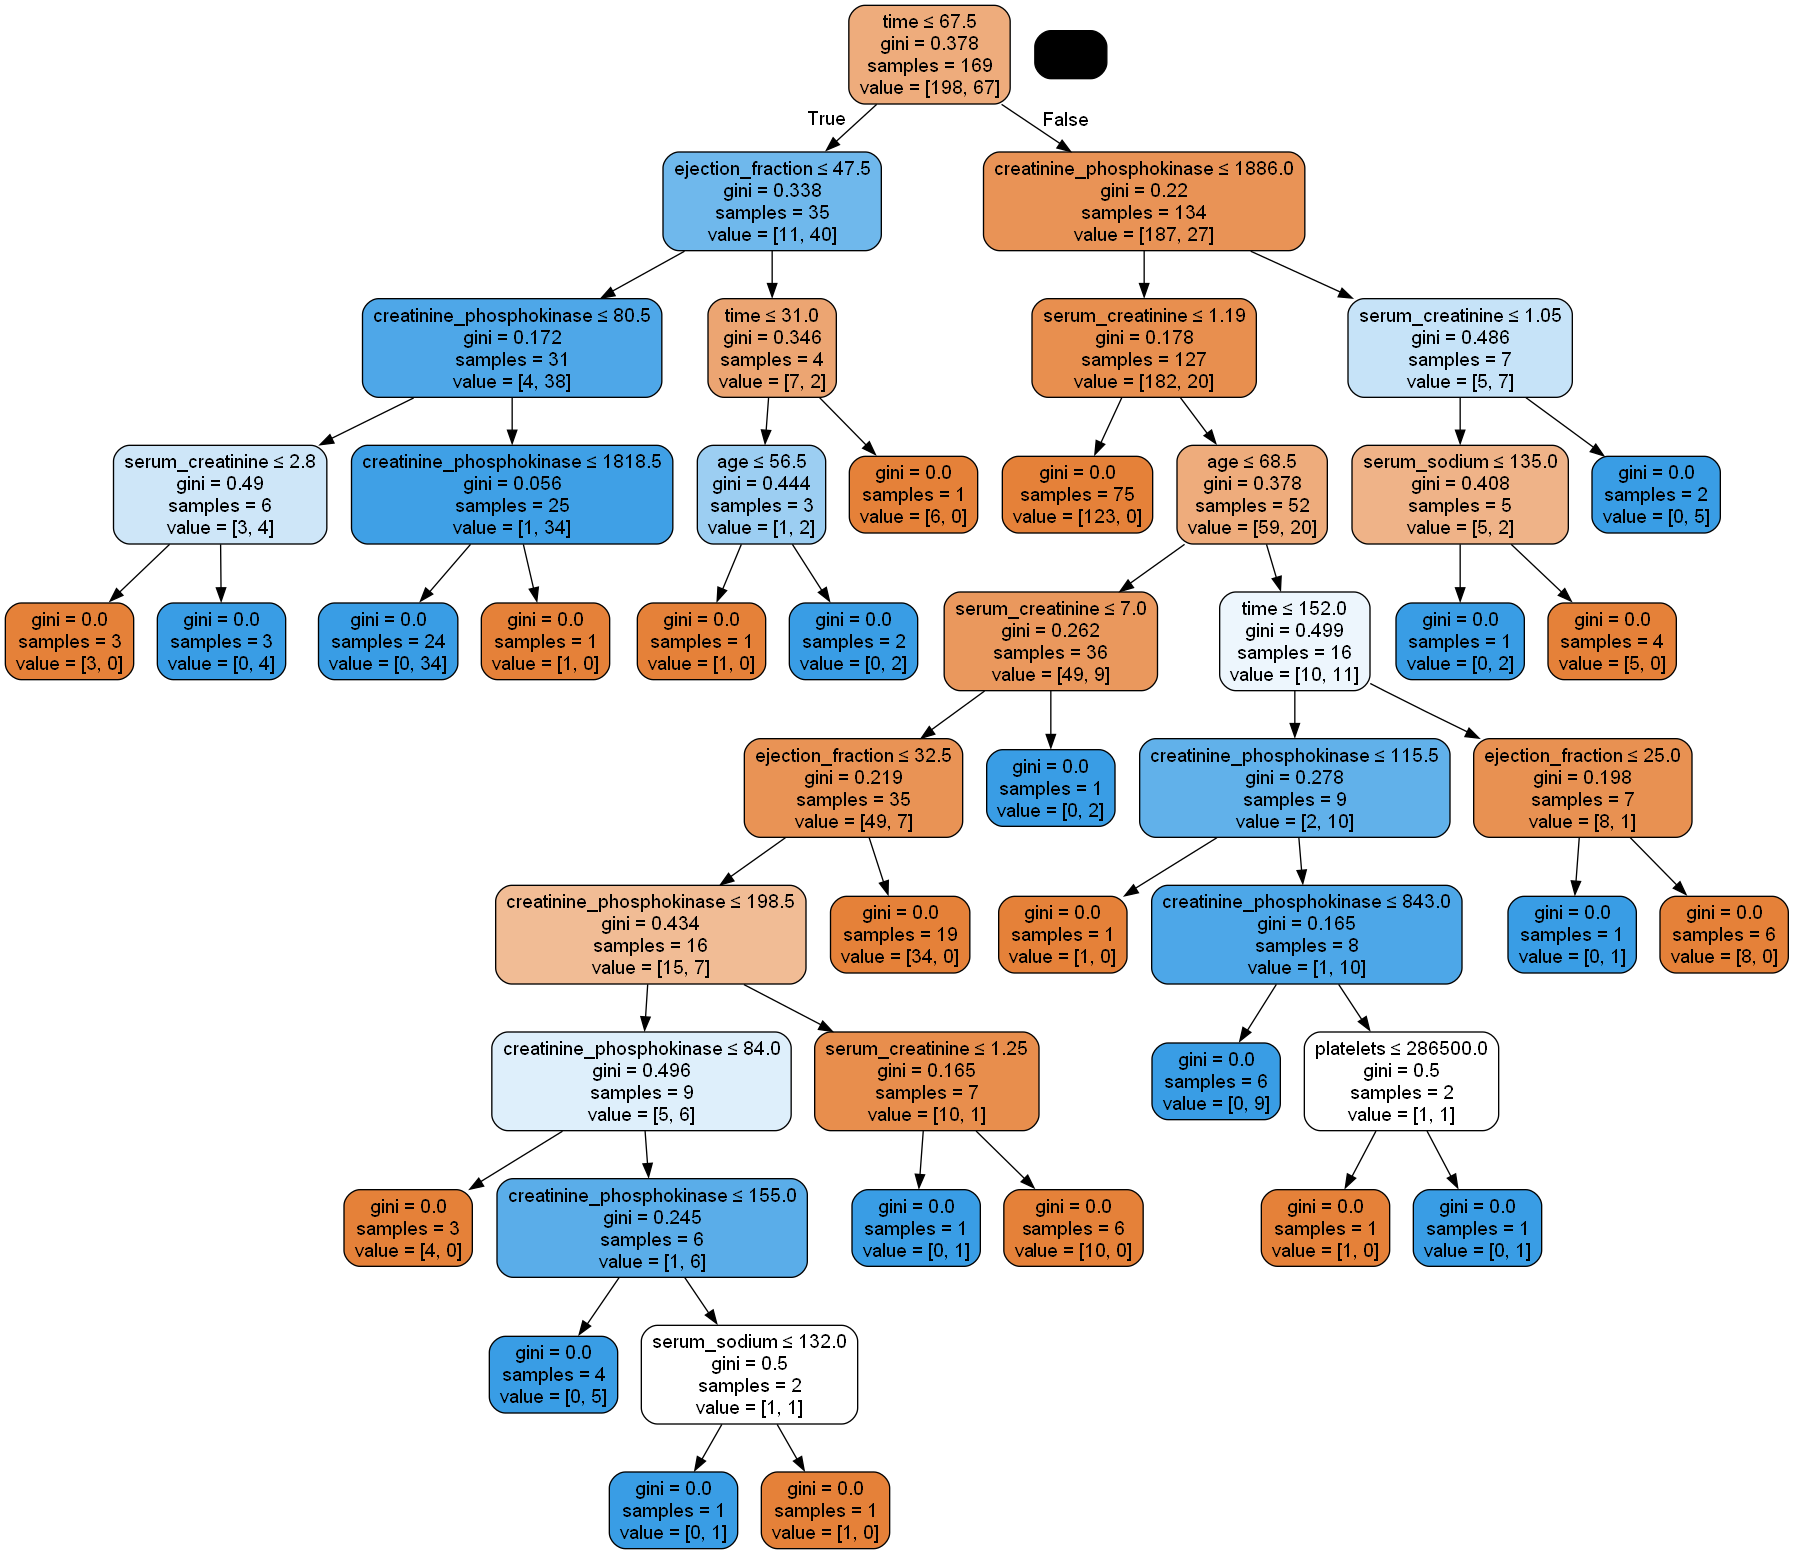

In [29]:
Image(get_png_tree(bc1.estimators_[1], column_labels))

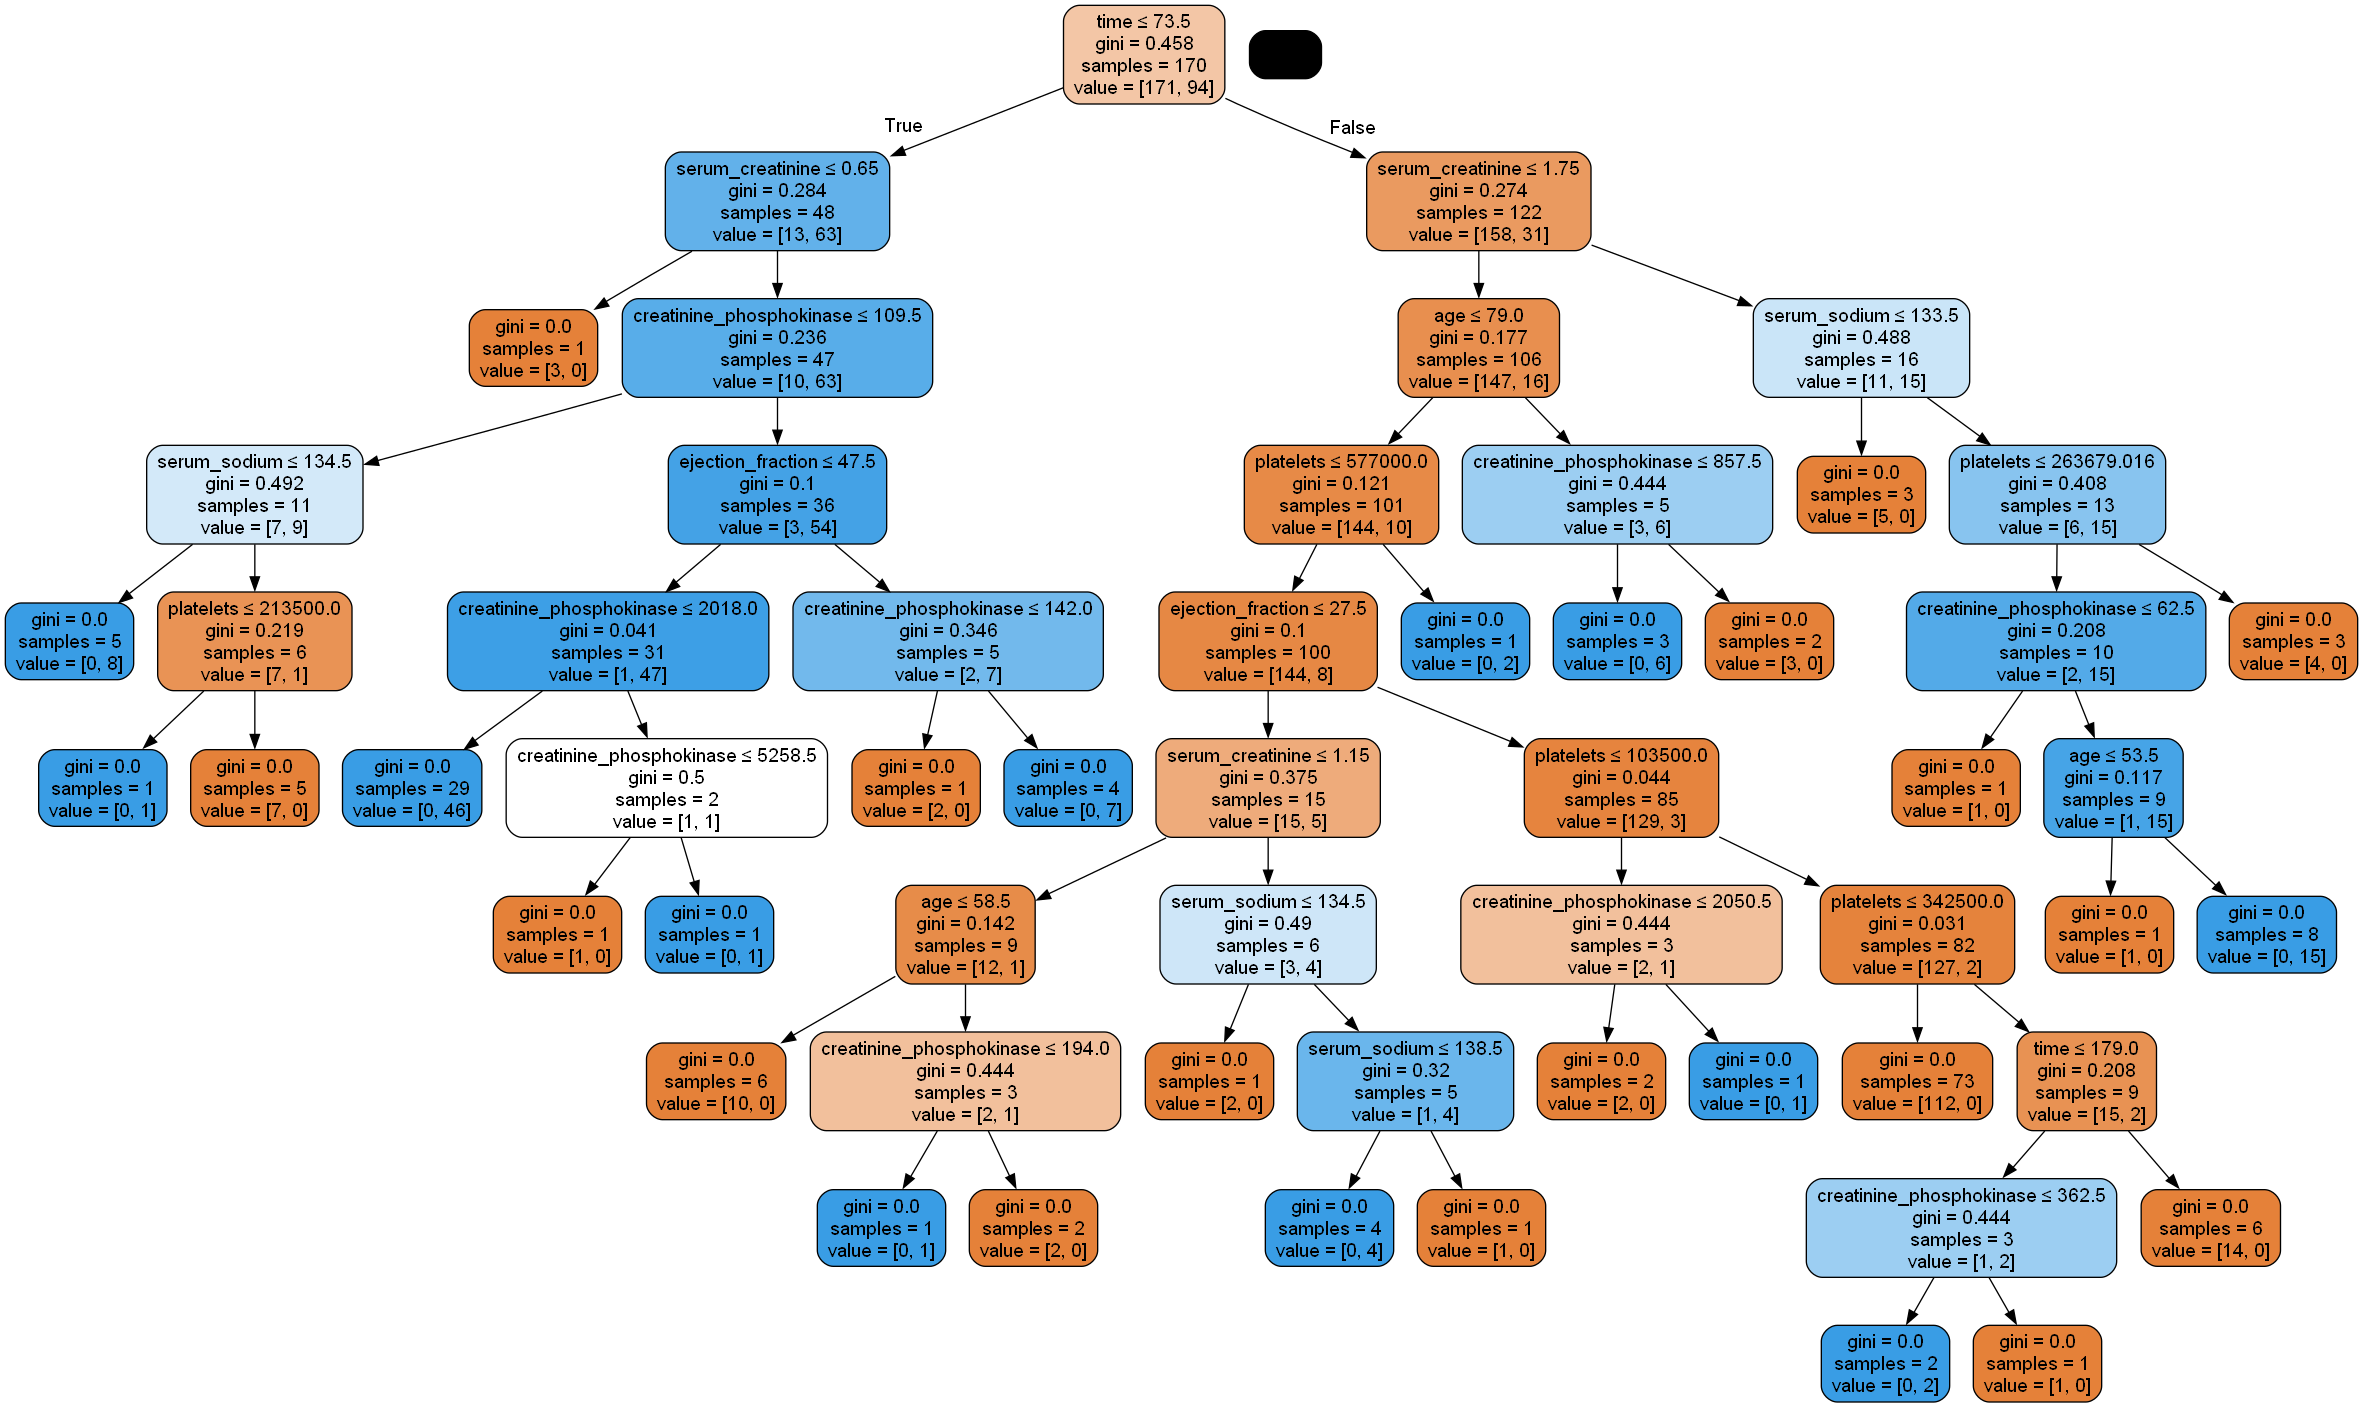

In [30]:
Image(get_png_tree(bc1.estimators_[2], column_labels))

# Случайный лес

In [31]:
# Обучим классификатор на 10 деревьях
forest = RandomForestClassifier(
    n_estimators=10,
    oob_score=True,
    random_state=9,
)
forest.fit(X_train, y_train)

y_train_predicted = forest.predict(X_train)
y_test_predicted = forest.predict(X_test)
print(classification_report(y_train, y_train_predicted), classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       180
           1       1.00      0.99      0.99        85

    accuracy                           1.00       265
   macro avg       1.00      0.99      1.00       265
weighted avg       1.00      1.00      1.00       265
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        22
           1       0.75      0.75      0.75         8

    accuracy                           0.87        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.87      0.87      0.87        30



C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


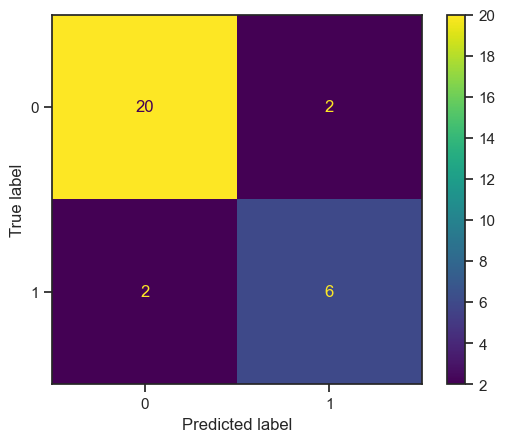

In [32]:
cm_log_forest = confusion_matrix(y_test, y_test_predicted, labels = forest.classes_)
display_ = ConfusionMatrixDisplay(
    confusion_matrix=cm_log_forest
)
display_.plot()

In [33]:
# Out-of-bag error, возвращаемый классификатором
forest.oob_score_, 1-forest.oob_score_

(0.7773584905660378, 0.22264150943396221)

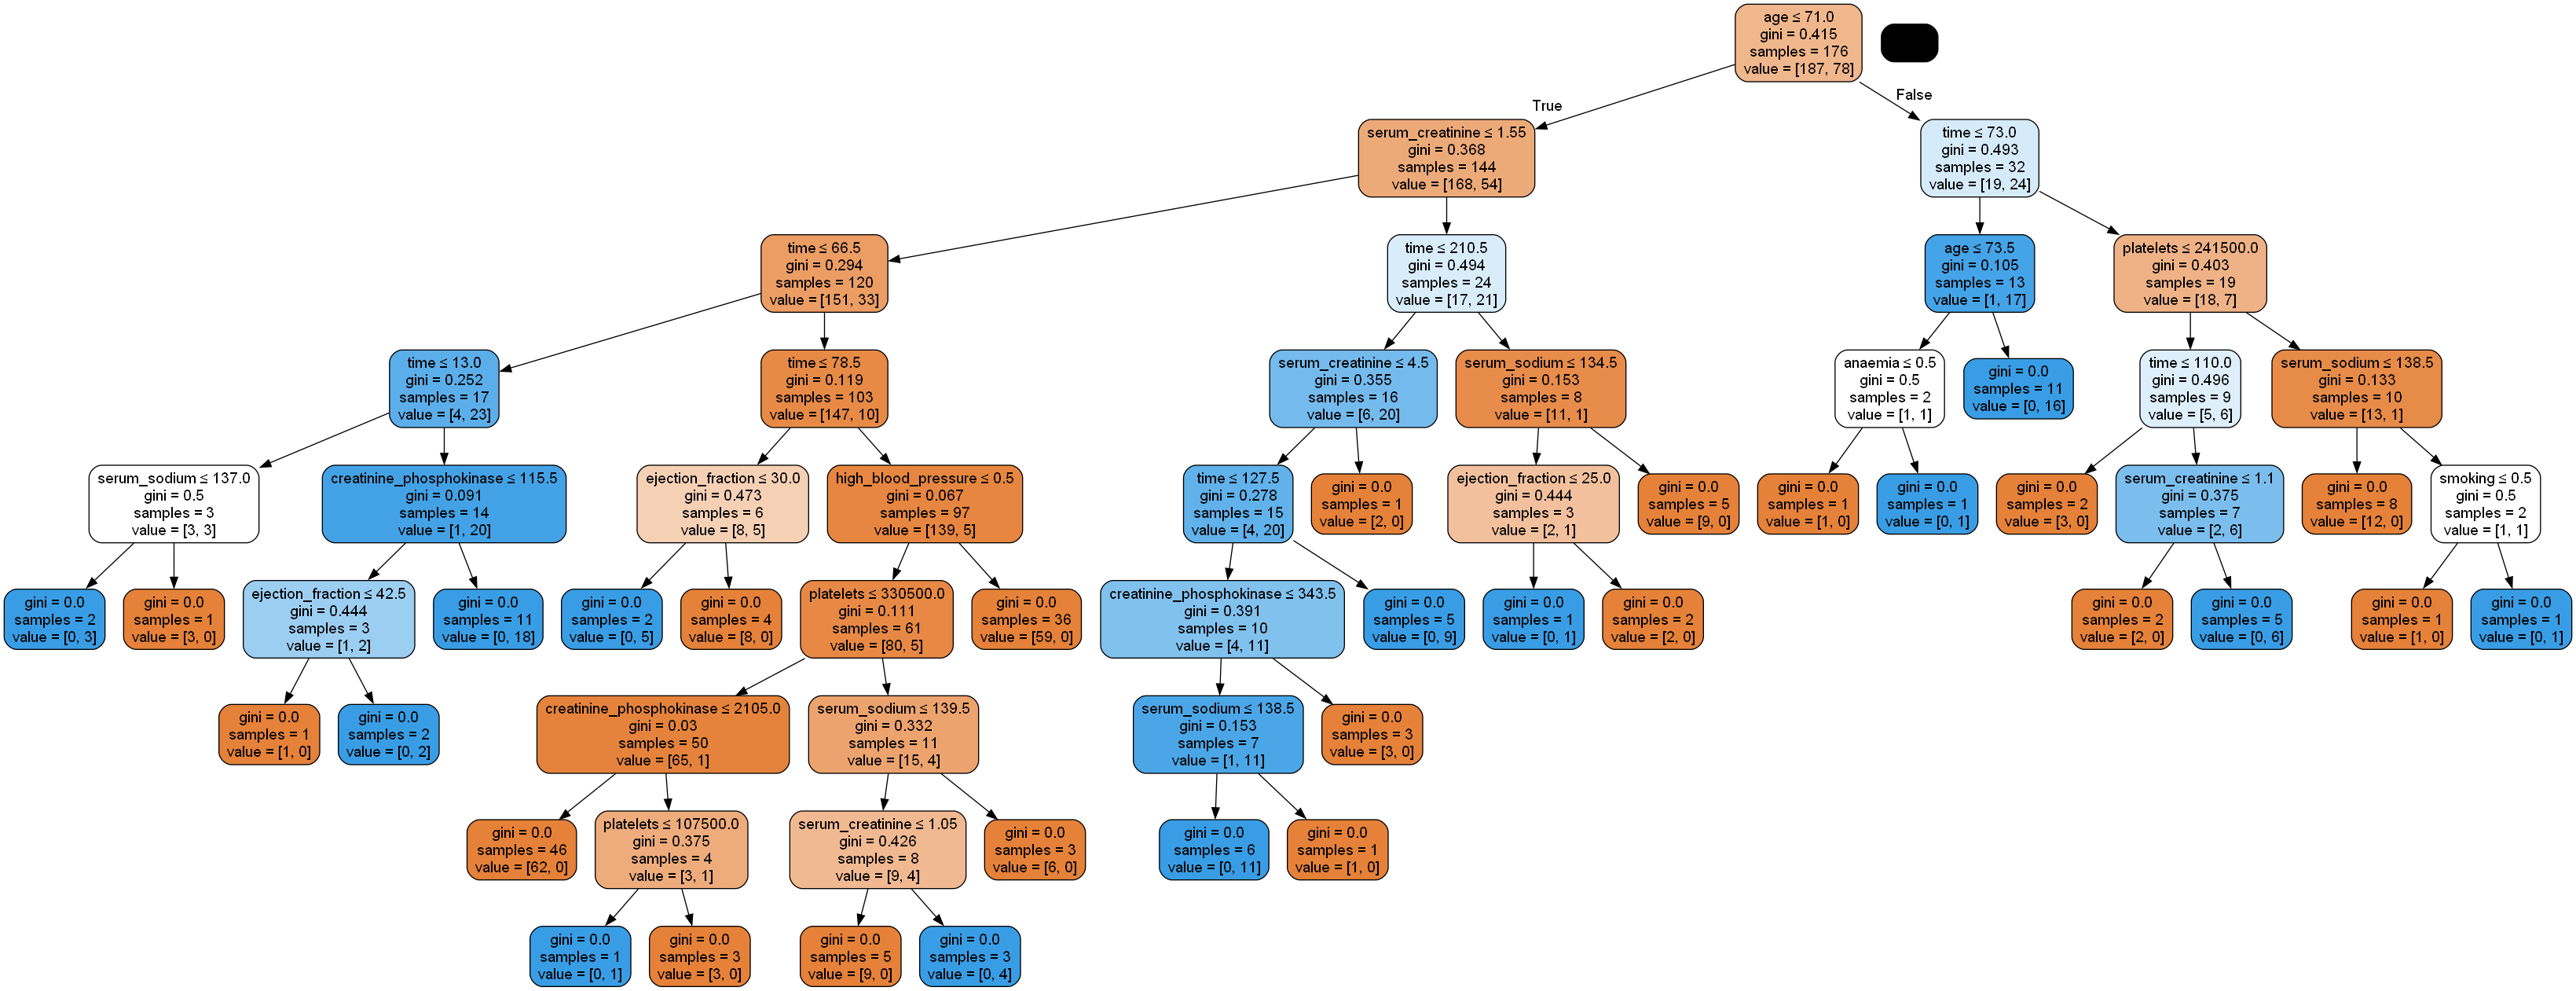

In [34]:
# Визуализация обученных решающих деревьев
Image(get_png_tree(forest.estimators_[0], column_labels))

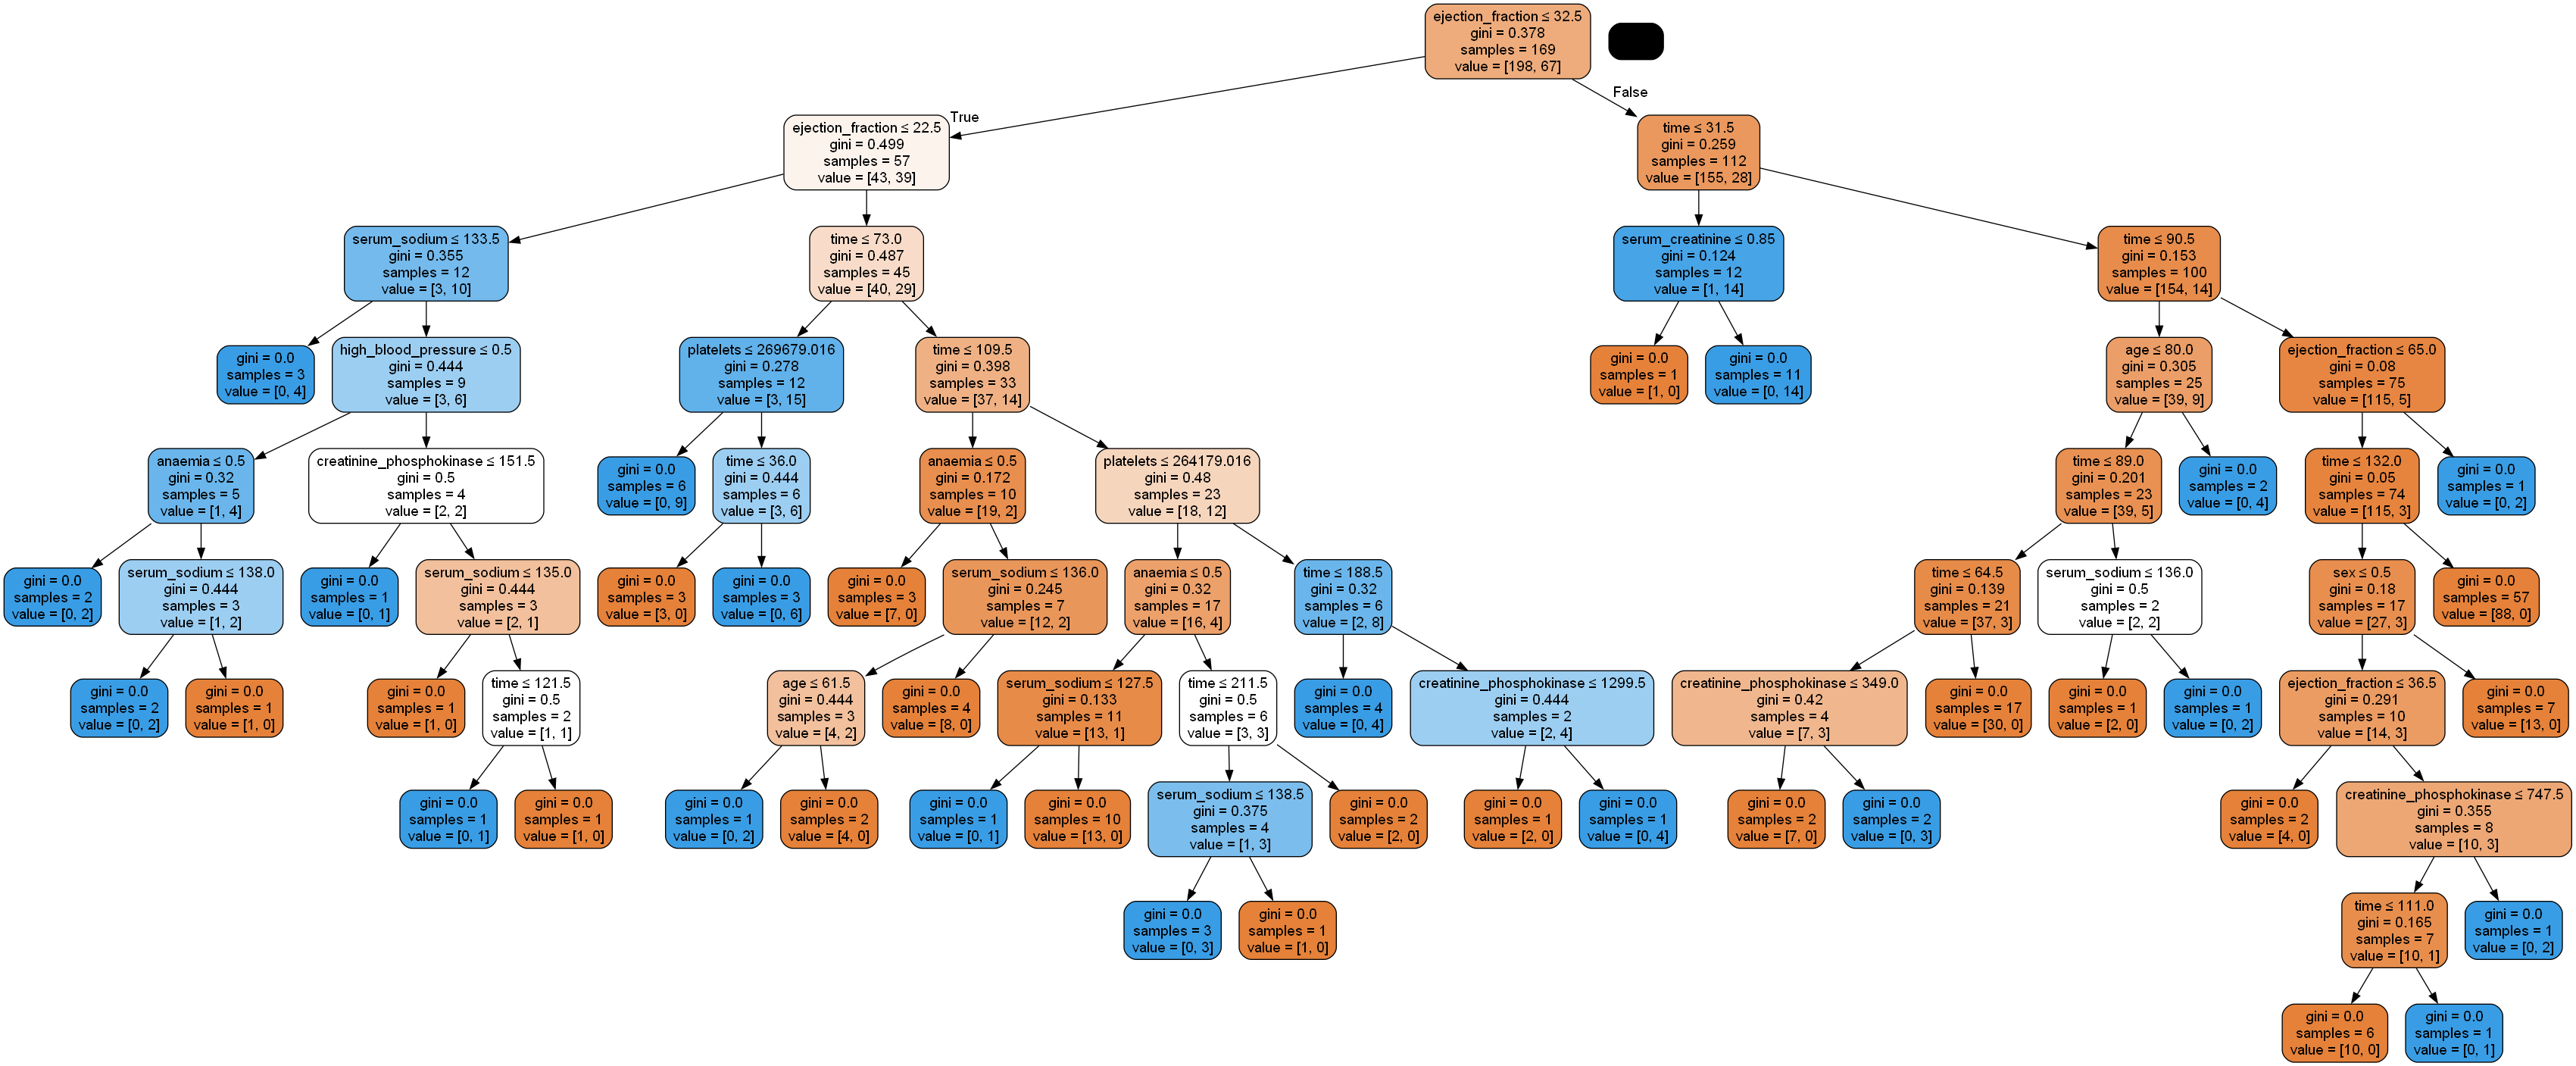

In [35]:
Image(get_png_tree(forest.estimators_[1], column_labels))

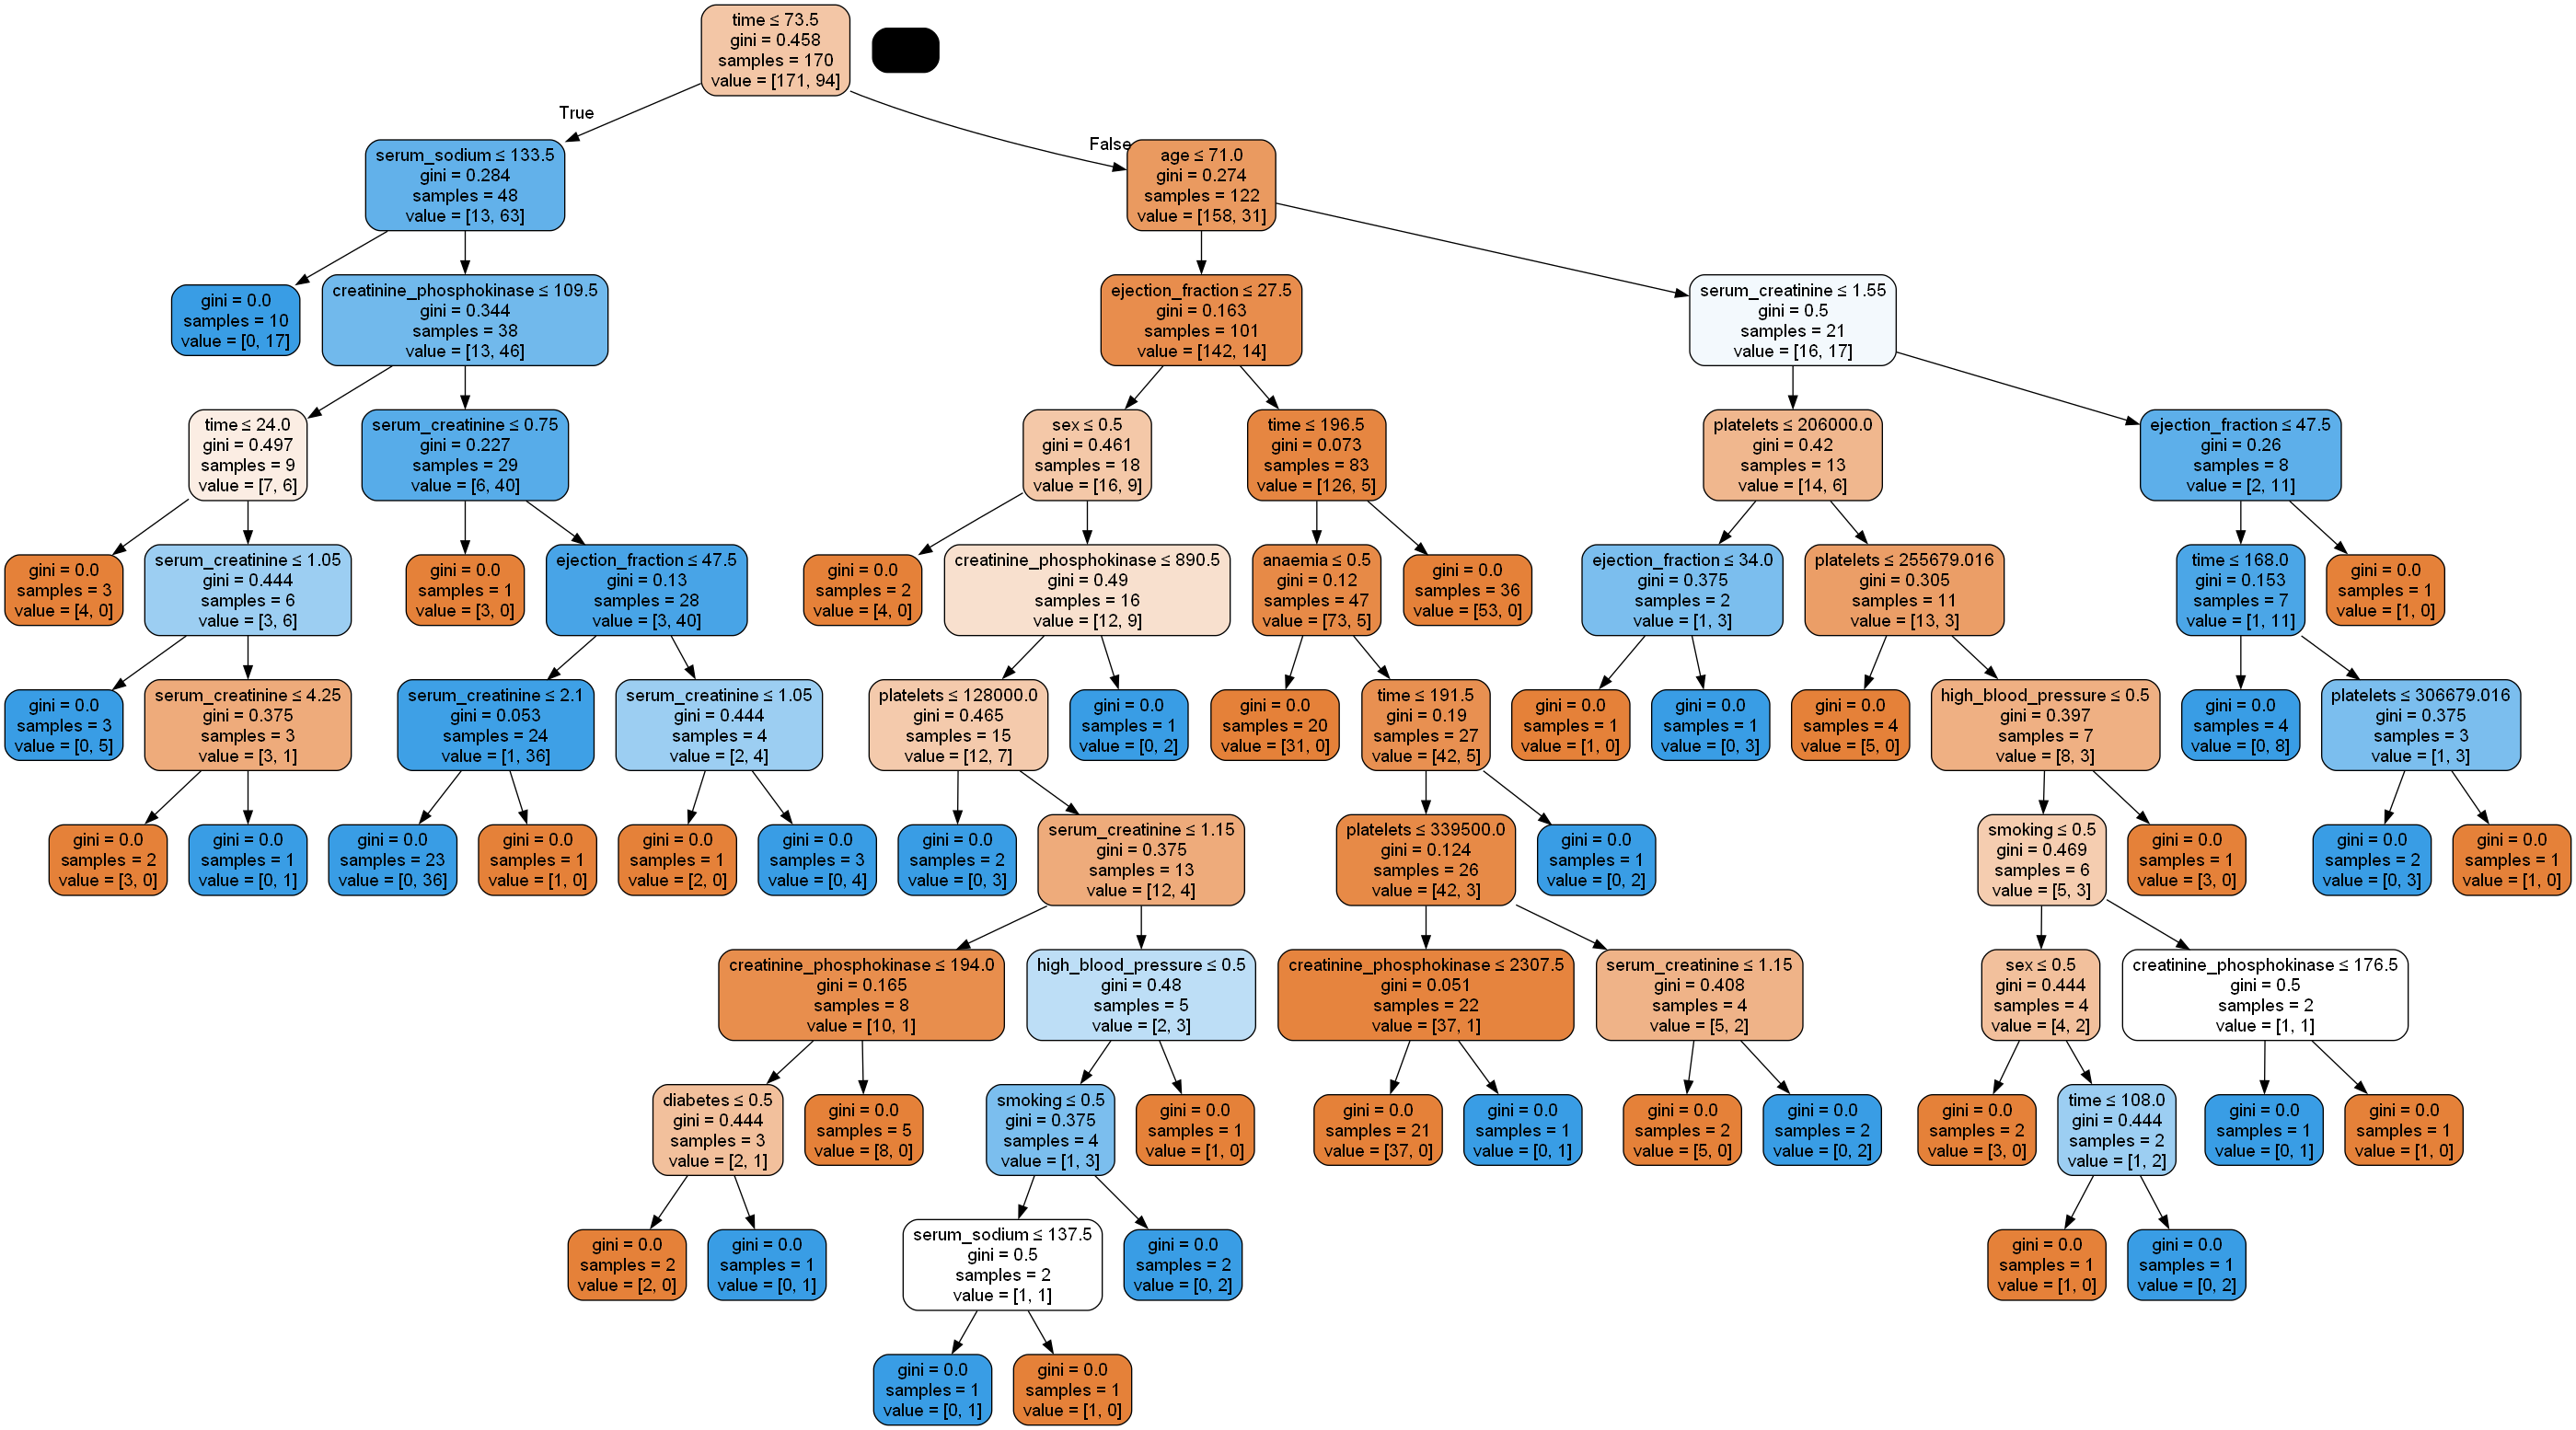

In [36]:
Image(get_png_tree(forest.estimators_[2], column_labels))

# XGBoost

<module 'matplotlib.pyplot' from 'C:\\Users\\Xiaomi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

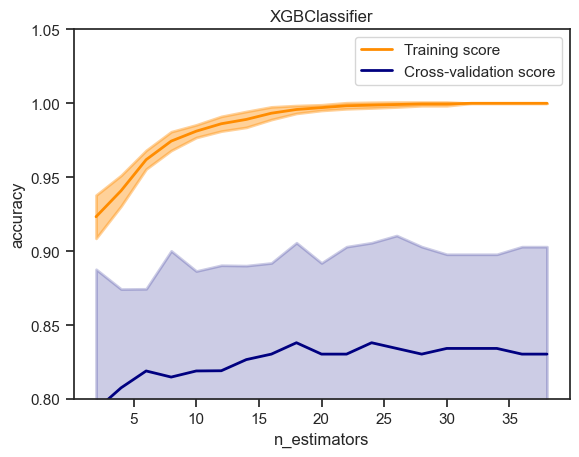

In [37]:
plot_validation_curve(
    XGBClassifier(
        max_depth=30,
        learning_rate=0.3,
        objective='binary:logistic',
    ),
    'XGBClassifier',
    X_train, y_train,
    param_name='n_estimators', param_range=range(2, 40, 2),
    cv=10, scoring="accuracy"
)

In [38]:
gbtree = XGBClassifier(
    n_estimators=20,
    max_depth=30,
    learning_rate=0.3,
    objective='binary:logistic',
    random_state=9
)
gbtree.fit(X_train, y_train)

y_train_predicted = gbtree.predict(X_train)
y_test_predicted = gbtree.predict(X_test)
print(classification_report(y_train, y_train_predicted), classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       180
           1       0.99      1.00      0.99        85

    accuracy                           1.00       265
   macro avg       0.99      1.00      1.00       265
weighted avg       1.00      1.00      1.00       265
               precision    recall  f1-score   support

           0       0.87      0.91      0.89        22
           1       0.71      0.62      0.67         8

    accuracy                           0.83        30
   macro avg       0.79      0.77      0.78        30
weighted avg       0.83      0.83      0.83        30



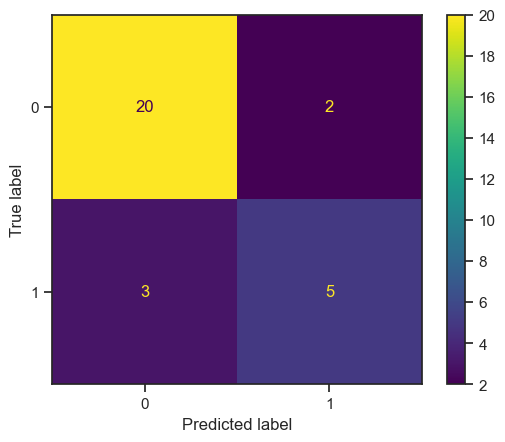

In [39]:
cm_log_gbtree = confusion_matrix(y_test, y_test_predicted, labels = gbtree.classes_)
display_ = ConfusionMatrixDisplay(
    confusion_matrix=cm_log_gbtree
)
display_.plot()

# Стэкинг

In [40]:
# Модели первого уровня
lr_clf = LogisticRegression(max_iter=10000)
dt_clf = DecisionTreeClassifier(random_state=9, max_depth=13)
rf_clf = forest

# Настаканные модели
stk1 = StackingClassifier(estimators=[('lr', lr_clf), ('dt', dt_clf)], final_estimator=dt_clf)
stk2 = StackingClassifier(estimators=[('lr', lr_clf), ('rf', rf_clf)], final_estimator=lr_clf)
stk3 = StackingClassifier(estimators=[('dt', dt_clf), ('rf', rf_clf)], final_estimator=lr_clf)

In [41]:
# Стэк #1
for clf, label in zip([lr_clf, dt_clf, stk1], ['LogisticRegression', 'DecisionTreeClassifier', 'Stacking']):
    clf.fit(X_train, y_train)
    y_stack_predict = clf.predict(X_test)
    if label == "Stacking":
        print(classification_report(y_test, y_stack_predict))
    else:
        print(f"Accuracy score: {accuracy_score(y_test, y_stack_predict)} {label}")

Accuracy score: 0.9 LogisticRegression
Accuracy score: 0.8 DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        22
           1       0.67      0.75      0.71         8

    accuracy                           0.83        30
   macro avg       0.79      0.81      0.79        30
weighted avg       0.84      0.83      0.84        30



In [42]:
# Стэк #2
for clf, label in zip([lr_clf, rf_clf, stk2], ['LogisticRegression', 'RandomForestClassifier', 'Stacking']):
    clf.fit(X_train, y_train)
    y_stack_predict = clf.predict(X_test)
    if label == "Stacking":
        print(classification_report(y_test, y_stack_predict))
    else:
        print(f"Accuracy score: {accuracy_score(y_test, y_stack_predict)} {label}")

Accuracy score: 0.9 LogisticRegression
Accuracy score: 0.8666666666666667 RandomForestClassifier
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       0.86      0.75      0.80         8

    accuracy                           0.90        30
   macro avg       0.89      0.85      0.87        30
weighted avg       0.90      0.90      0.90        30



C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Xia

In [43]:
# Стэк #3
for clf, label in zip([dt_clf, rf_clf, stk3], ['DecisionTreeClassifier', 'RandomForestClassifier', 'Stacking']):
    clf.fit(X_train, y_train)
    y_stack_predict = clf.predict(X_test)
    if label == "Stacking":
        print(classification_report(y_test, y_stack_predict))
    else:
        print(f"Accuracy score: {accuracy_score(y_test, y_stack_predict)} {label}")

Accuracy score: 0.8 DecisionTreeClassifier
Accuracy score: 0.8666666666666667 RandomForestClassifier
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        22
           1       0.75      0.75      0.75         8

    accuracy                           0.87        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.87      0.87      0.87        30



C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Xia

# Многослойный персептрон

In [44]:
ml_perc = MLPClassifier(
    activation="logistic",
    max_iter=10000,
    shuffle=True,
    random_state=9,
)
ml_perc.fit(X_train, y_train)

y_train_predicted = ml_perc.predict(X_train)
y_test_predicted = ml_perc.predict(X_test)
print(classification_report(y_train, y_train_predicted), classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81       180
           1       0.00      0.00      0.00        85

    accuracy                           0.68       265
   macro avg       0.34      0.50      0.40       265
weighted avg       0.46      0.68      0.55       265
               precision    recall  f1-score   support

           0       0.73      1.00      0.85        22
           1       0.00      0.00      0.00         8

    accuracy                           0.73        30
   macro avg       0.37      0.50      0.42        30
weighted avg       0.54      0.73      0.62        30



C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

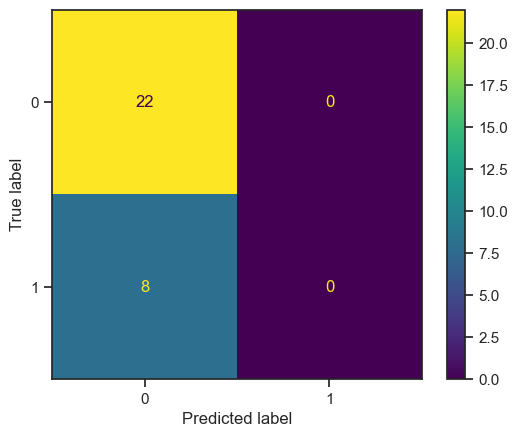

In [45]:
cm_log_perc = confusion_matrix(y_test, y_test_predicted, labels=ml_perc.classes_)
display_ = ConfusionMatrixDisplay(
    confusion_matrix=cm_log_perc
)
display_.plot()

# МГУА

In [46]:
from gmdhpy.gmdh import Classifier as GMDHClassifier
gmdh = GMDHClassifier(
    n_jobs=5,
    max_layer_count=50,
    ref_functions='quadratic'
)
gmdh.fit(X_train, y_train, validation_data=(X_test, y_test))

train layer0 in 1.37 sec
train layer1 in 0.31 sec
train layer2 in 0.30 sec
train layer3 in 0.34 sec
train layer4 in 0.29 sec
train layer5 in 0.30 sec
train layer6 in 0.28 sec
train layer7 in 0.29 sec
train layer8 in 0.29 sec
train layer9 in 0.30 sec
train layer10 in 0.29 sec
train layer11 in 0.30 sec
train layer12 in 0.31 sec
train layer13 in 0.32 sec


In [47]:
y_train_predicted = gmdh.predict_proba(X_train)
y_test_predicted = gmdh.predict_proba(X_test)

for i in range(y_train_predicted.shape[0]):
    y_train_predicted[i] = 1.0 if y_train_predicted[i] > 0.5 else 0.0

for i in range(y_test_predicted.shape[0]):
    y_test_predicted[i] = 1.0 if y_test_predicted[i] > 0.5 else 0.0

print(classification_report(y_train, y_train_predicted), classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       180
           1       0.81      0.61      0.70        85

    accuracy                           0.83       265
   macro avg       0.82      0.77      0.79       265
weighted avg       0.83      0.83      0.82       265
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       0.88      0.88      0.88         8

    accuracy                           0.93        30
   macro avg       0.91      0.91      0.91        30
weighted avg       0.93      0.93      0.93        30



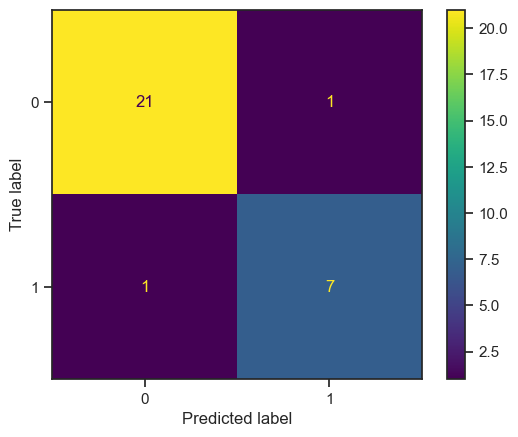

In [48]:
cm_log_gmdh = confusion_matrix(y_test, y_test_predicted, labels=forest.classes_)
display_ = ConfusionMatrixDisplay(
    confusion_matrix=cm_log_gmdh
)
display_.plot()
